### Concrete ML configuration with docker (didn't work)
https://docs.zama.ai/concrete-ml/get-started/pip_installing#installation-using-docker
Installation only available via [Docker](https://docs.docker.com/desktop/install/windows-install/) on Windows Machine.
```docker
docker pull zamafhe/concrete-ml:latest
```


### Concrete ML configuration with Windows Subsystem for Linux (WSL)

- install WLS: 
```powershell
        wsl --install
```
- install conda and python 3.11, [installation guide](https://gist.github.com/kauffmanes/5e74916617f9993bc3479f401dfec7da)
- install concrete ML
```bash
        pip install -U pip wheel setuptools
        pip install concrete-ml
```
- configure interpreter under WSL (e.g. via [Pycharm](https://www.jetbrains.com/help/pycharm/using-wsl-as-a-remote-interpreter.html))

![pycharm_wls](pycharm_wsl.png)

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import LogisticRegression

# Create the data for classification:
X, y = make_classification(
    n_features=30,
    n_redundant=0,
    n_informative=2,
    random_state=2,
    n_clusters_per_class=1,
    n_samples=250,
)

# Retrieve train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate the model:
model = LogisticRegression(n_bits=8)

# Fit the model:
model.fit(X_train, y_train)

# Evaluate the model on the test set in clear:
y_pred_clear = model.predict(X_test)

# Compile the model:
model.compile(X_train)

# Perform the inference in FHE:
y_pred_fhe = model.predict(X_test, fhe="execute")

# Assert that FHE predictions are the same as the clear predictions:
print(
    f"{(y_pred_fhe == y_pred_clear).sum()} examples over {len(y_pred_fhe)} "
    "have an FHE inference equal to the clear inference."
)

# Output:
#  100 examples over 100 have an FHE inference equal to the clear inference

100 examples over 100 have an FHE inference equal to the clear inference.


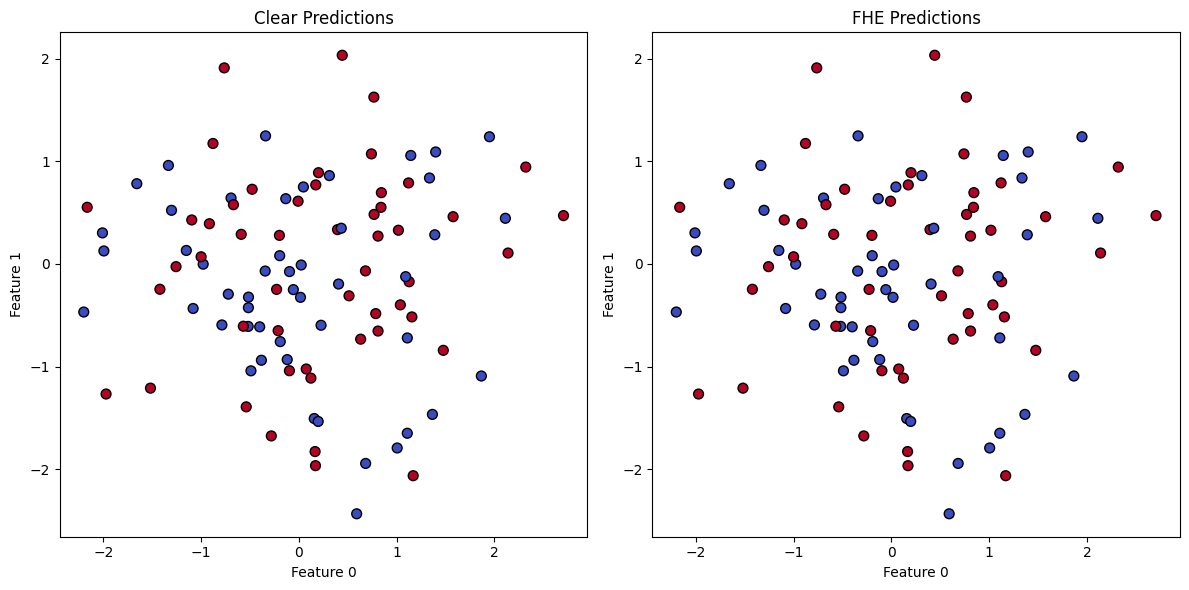

In [2]:
import matplotlib.pyplot as plt

# Choose two features to plot from X_test (e.g., feature 0 and feature 1)
feature_1 = 0
feature_2 = 1

# Create a figure and axis for the scatter plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of clear predictions
ax[0].scatter(X_test[:, feature_1], X_test[:, feature_2], c=y_pred_clear, cmap='coolwarm', edgecolor='k', s=50)
ax[0].set_title("Clear Predictions")
ax[0].set_xlabel(f"Feature {feature_1}")
ax[0].set_ylabel(f"Feature {feature_2}")

# Scatter plot of FHE predictions
ax[1].scatter(X_test[:, feature_1], X_test[:, feature_2], c=y_pred_fhe, cmap='coolwarm', edgecolor='k', s=50)
ax[1].set_title("FHE Predictions")
ax[1].set_xlabel(f"Feature {feature_1}")
ax[1].set_ylabel(f"Feature {feature_2}")

# Display the plot
plt.tight_layout()
plt.show()
